In [1]:
import xarray as xr
import numpy as np

#import gribscan
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import intake
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
def ifs_to_latlon(ds):
    '''
    Uses the latitude-longitude information encoded in the regular grid IFS output to reconstructed the regular grid
    '''
    return ds.rename({'value':'latlon'}).set_index(latlon=("lat","lon")).unstack("latlon")

# -- regional average
def wgt_areaave(indat, latS, latN, lonW, lonE):
  lat=indat.lat
  lon=indat.lon

  if ( ((lonW < 0) or (lonE < 0 )) and (lon.values.min() > -1) ):
     anm=indat.assign_coords(lon=( (lon + 180) % 360 - 180) )
     longitude=( (lon + 180) % 360 - 180)
  else:
     anm=indat

  iplat = lat.where( (lat >= latS ) & (lat <= latN), drop=True)
  iplon = lon.where( (lon >= lonW ) & (lon <= lonE), drop=True)

#  print(iplat)
#  print(iplon)
  wgt = np.cos(np.deg2rad(lat))
  odat=anm.sel(lat=iplat,lon=iplon).weighted(wgt).mean(("lon", "lat"), skipna=True)
  return(odat)

In [3]:
ds = xr.open_zarr("reference::/work/bm1344/a270228/phase1_hist/gribscan_1m_REGULARLL/jsons.1950-2014/sfc.dir/atm2d_avg.json", consolidated=False)
ds

<xarray.Dataset>
Dimensions:    (time: 780, value: 1038240)
Coordinates:
    lat        (value) float64 dask.array<chunksize=(1038240,), meta=np.ndarray>
    lon        (value) float64 dask.array<chunksize=(1038240,), meta=np.ndarray>
  * time       (time) datetime64[ns] 1950-01-15T12:00:00 ... 2014-12-15T12:00:00
Dimensions without coordinates: value
Data variables: (12/43)
    cprate     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    erate      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    m10u       (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    m10v       (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    m2d        (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    m2sh       (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    ...         ...
    mtnlwrf    (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    mtnlwrfcs  (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    mtnswrf    (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    mtnswrfcs  (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    mtsfr      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    tprate     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [4]:
tp=ds['tprate'] * 86400000
tp= ifs_to_latlon(tp)
tp

<xarray.DataArray 'tprate' (time: 780, lat: 721, lon: 1440)>
dask.array<reshape, shape=(780, 721, 1440), dtype=float64, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 1950-01-15T12:00:00 ... 2014-12-15T12:00:00

In [5]:
tp_clim= tp.sel(time=slice('1979', '2008')).mean('time')
#mean2t_clim= mean2t[420:,:,:].mean('time')
tp_clim.coords['lon'] = tp_clim.coords['lon'] % 360
tp_clim = tp_clim.sortby(tp_clim.lon)
tp_clim

<xarray.DataArray 'tprate' (lat: 721, lon: 1440)>
dask.array<getitem, shape=(721, 1440), dtype=float64, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8

In [6]:
eerie_cat=intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")
eerie_cat

obs=eerie_cat['dkrz.disk.observations']['MSWEP']['past']['monthly'].to_dask()
#print(list(obs))
obs

<xarray.Dataset>
Dimensions:        (lat: 1800, lon: 3600, time: 502)
Coordinates:
  * lat            (lat) float32 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon            (lon) float32 -179.9 -179.8 -179.8 ... 179.8 179.9 179.9
  * time           (time) datetime64[ns] 1979-02-01 1979-03-01 ... 2020-11-01
Data variables:
    precipitation  (time, lat, lon) float32 dask.array<chunksize=(32, 113, 450), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed May 24 00:58:27 2023: cdo -f nc mergetime 197902.nc 197...

In [7]:
tp_obs=obs['precipitation'] / 30
tp_obs=tp_obs[:,::-1,:]
tp_obs

<xarray.DataArray 'precipitation' (time: 502, lat: 1800, lon: 3600)>
dask.array<getitem, shape=(502, 1800, 3600), dtype=float32, chunksize=(32, 113, 450), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * lon      (lon) float32 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 179.9
  * time     (time) datetime64[ns] 1979-02-01 1979-03-01 ... 2020-11-01

In [8]:
tp_obs_clim= tp_obs.sel(time=slice('1979', '2008')).mean('time')

tp_obs_clim.coords['lon'] = tp_obs_clim.coords['lon'] % 360
tp_obs_clim = tp_obs_clim.sortby(tp_obs_clim.lon)
tp_obs_clim

<xarray.DataArray 'precipitation' (lat: 1800, lon: 3600)>
dask.array<getitem, shape=(1800, 3600), dtype=float32, chunksize=(113, 450), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * lon      (lon) float32 0.05 0.15 0.25 0.35 0.45 ... 359.6 359.8 359.9 360.0

In [9]:
import numpy as np
import xarray as xr
from scipy.interpolate import RegularGridInterpolator

# Extract latitude and longitude coordinates
lat_obs = tp_obs_clim.coords['lat'].values   # Original latitudes of tp_obs
lon_obs = tp_obs_clim.coords['lon'].values   # Original longitudes of tp_obs

lat_target = tp_clim.coords['lat'].values  # Target latitudes from tp
lon_target = tp_clim.coords['lon'].values  # Target longitudes from tp


# Convert tp_obs to numpy array
tp_obs_array = tp_obs_clim.values

# Create the interpolator
interpolator = RegularGridInterpolator(
    (lat_obs, lon_obs),  # Source grid
    tp_obs_array,        # Source data
    method="linear",     # Bilinear interpolation
    bounds_error=False,  # Allow extrapolation
    fill_value=np.nan    # Fill with NaN outside bounds
)

# Create the meshgrid for target points
lon_target_mesh, lat_target_mesh = np.meshgrid(lon_target, lat_target)

# Stack and reshape for interpolation
target_points = np.array([lat_target_mesh.ravel(), lon_target_mesh.ravel()]).T

# Perform interpolation
tp_obs_clim_interpolated = interpolator(target_points)

# Reshape back to target grid shape
tp_obs_clim_interpolated = tp_obs_clim_interpolated.reshape(len(lat_target), len(lon_target))

# Convert back to xarray DataArray (optional)
tp_obs_clim_regridded = xr.DataArray(
    tp_obs_clim_interpolated,
    dims=("lat", "lon"),
    coords={"lat": lat_target, "lon": lon_target},
    name="tp_obs_clim_regridded"
)

tp_obs_clim_regridded


<xarray.DataArray 'tp_obs_clim_regridded' (lat: 721, lon: 1440)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 0.12411791, 0.1240976 , ..., 0.12428042, 0.1242688 ,
        0.12429782],
       [       nan, 0.12603588, 0.12563982, ..., 0.12580086, 0.12607216,
        0.12625348],
       ...,
       [       nan, 0.66285399, 0.66289172, ..., 0.66247103, 0.6626001 ,
        0.66263053],
       [       nan, 0.66928965, 0.66941154, ..., 0.66955084, 0.66944641,
        0.66930717],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8

In [10]:
diff = tp_clim - tp_obs_clim_regridded

diff

<xarray.DataArray (lat: 721, lon: 1440)>
dask.array<sub, shape=(721, 1440), dtype=float64, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8

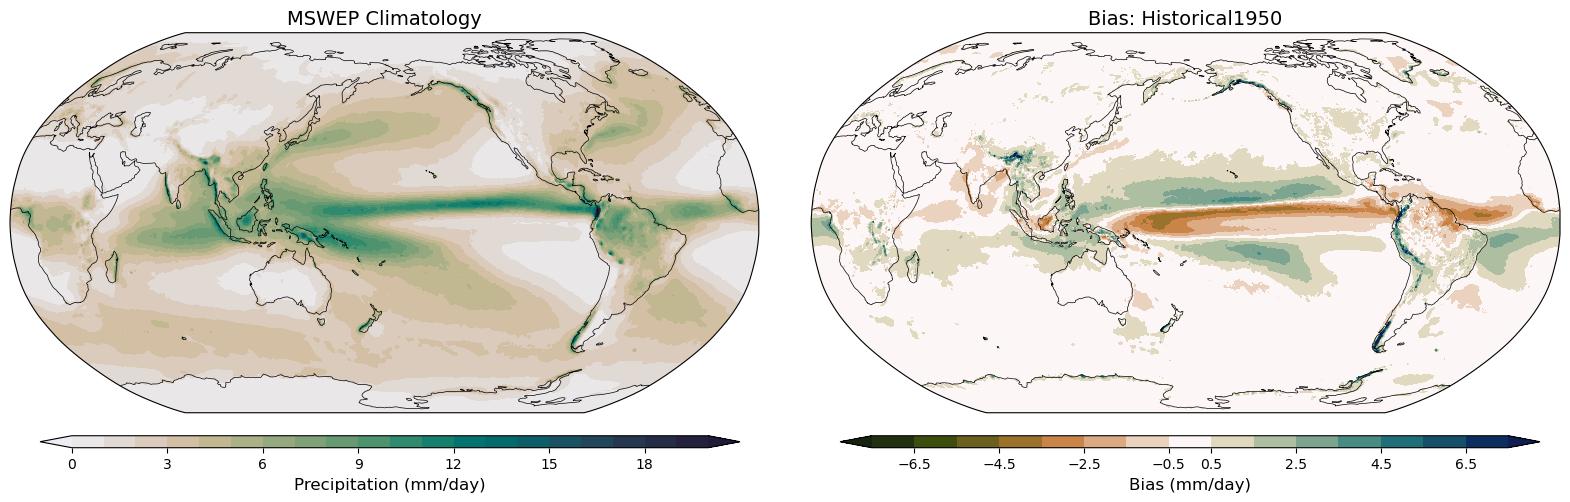

In [12]:

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import cmocean

# Assuming `tp_obs_clim_regridded` and `diff` are your data arrays with dimensions corresponding to latitudes and longitudes
# Extract longitude and latitude
lon1 = tp_obs_clim_regridded['lon'].values
lat1 = tp_obs_clim_regridded['lat'].values

lon2 = diff['lon'].values
lat2 = diff['lat'].values

# Define levels for bias
num_bias_levels = 21
bias_levels1 = np.linspace(0, 20, num_bias_levels)  # Adjust as per your data range
bias_levels2 = np.linspace(-7.5, 7.5, 16)  # Adjust as per your data range

# Create the plot
fig, axes = plt.subplots(1, 2, figsize=(20, 6), subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

# First subplot
bias_contour1 = axes[0].contourf(
    lon1, lat1, tp_obs_clim_regridded,
    levels=bias_levels1, cmap=cmocean.cm.rain,
    transform=ccrs.PlateCarree(), extend='both'
)
axes[0].add_feature(cfeature.COASTLINE, linewidth=0.5)
axes[0].set_title("MSWEP Climatology", fontsize=14)

# Second subplot
bias_contour2 = axes[1].contourf(
    lon2, lat2, diff,
    levels=bias_levels2, cmap=cmocean.cm.tarn,
    transform=ccrs.PlateCarree(), extend='both'
)
axes[1].add_feature(cfeature.COASTLINE, linewidth=0.5)
axes[1].set_title("Bias: Historical1950", fontsize=14)

# Adjust space between subplots
fig.subplots_adjust(wspace=0.07)

# Add colorbars
cbar_ax1 = fig.add_axes([0.14, 0.12, 0.35, 0.02])  # Adjust position as needed
cbar1 = fig.colorbar(bias_contour1, cax=cbar_ax1, orientation='horizontal')
cbar1.set_label("Precipitation (mm/day)", fontsize=12)

cbar_ax2 = fig.add_axes([0.54, 0.12, 0.35, 0.02])  # Adjust position as needed
cbar2 = fig.colorbar(bias_contour2, cax=cbar_ax2, orientation='horizontal', ticks=[-6.5, -4.5, -2.5, -0.5, 0.5, 2.5, 4.5, 6.5])
cbar2.set_label("Bias (mm/day)", fontsize=12)

# Save the combined plot
plt.savefig("tot_precip_mswep_hist_clim_bias_eerie_plot.png", dpi=300, bbox_inches='tight')
plt.show()
